## Sanity check (synthetic manifolds)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import NearestNeighbors

In [2]:
RAND_SEED = 42
EPS = 1e-12
N = 2000                
MU_FRACTION = 0.9       
rng = np.random.default_rng(RAND_SEED)

In [3]:
def make_isotropic_gaussian(n=N, d=16):
    return rng.normal(size=(n, d)).astype(np.float32)


def make_anisotropic_gaussian(n=N, d=16, cond=100.0):
    ev = np.geomspace(1.0, 1.0 / cond, d)
    Q, _ = np.linalg.qr(rng.normal(size=(d, d)))
    A = Q @ np.diag(np.sqrt(ev))
    Z = rng.normal(size=(n, d))
    return (Z @ A.T).astype(np.float32)


def make_linear_subspace_gaussian(n=N, ambient=64, intrinsic=4, noise=1e-3):
    Q, _ = np.linalg.qr(rng.normal(size=(ambient, intrinsic)))
    Z = rng.normal(size=(n, intrinsic))
    X = Z @ Q.T
    X += rng.normal(scale=noise, size=X.shape)
    return X.astype(np.float32)


def make_swiss_roll_points(n=N, noise=0.05):
    X, _ = make_swiss_roll(n_samples=n, noise=noise, random_state=RAND_SEED)
    return X.astype(np.float32)


def default_manifolds():
    return {
        "IG-16": {"X": make_isotropic_gaussian(n=N, d=16), "true_id": 16, "note": "isotropic Gaussian"},
        "AG-16": {"X": make_anisotropic_gaussian(n=N, d=16, cond=100.0), "true_id": 16, "note": "anisotropic Gaussian"},
        "LR-4":  {"X": make_linear_subspace_gaussian(n=N, ambient=64, intrinsic=4), "true_id": 4,  "note": "4D linear subspace in R^64"},
        "SR-2":  {"X": make_swiss_roll_points(n=N, noise=0.05), "true_id": 2,  "note": "2D swiss roll in R^3"},
    }


In [4]:
def _center(X: np.ndarray) -> np.ndarray:
    return X - X.mean(axis=0, keepdims=True)


def _cov_eigvals(X: np.ndarray) -> np.ndarray:
    Xc = _center(X).astype(np.float64)
    cov = (Xc.T @ Xc) / max(1, (Xc.shape[0] - 1))
    lam = np.linalg.eigvalsh(cov)
    return np.clip(lam, EPS, None)


def _knn_distances(X: np.ndarray, k: int) -> np.ndarray:
    X = X.astype(np.float64)
    nn = NearestNeighbors(n_neighbors=k + 1, algorithm="auto").fit(X)
    dists, _ = nn.kneighbors(X, return_distance=True)
    return dists[:, 1:] + EPS


In [5]:
def isoscore_like_from_eigs(lam: np.ndarray) -> float:
    '''
    IsoScore-style isotropy proxy from covariance eigenvalues.

    We use the δ(X) construction (spectrum uniformity) and map it to [0,1] via 1-δ.
    '''
    D = lam.shape[0]
    lam_hat = (np.sqrt(D) * lam) / (np.linalg.norm(lam) + EPS)
    delta = np.sqrt((np.linalg.norm(lam_hat - 1.0) ** 2) / (D - np.sqrt(D) + EPS))
    return float(np.clip(1.0 - delta, 0.0, 1.0))


def spectral_flatness_from_eigs(lam: np.ndarray) -> float:
    gm = np.exp(np.mean(np.log(lam + EPS)))
    am = np.mean(lam)
    return float(gm / (am + EPS))


def effective_rank_from_eigs(lam: np.ndarray) -> float:
    p = lam / (lam.sum() + EPS)
    H = -np.sum(p * np.log(p + EPS))
    return float(np.exp(H))


def participation_ratio_from_eigs(lam: np.ndarray) -> float:
    return float((lam.sum() ** 2) / (np.sum(lam * lam) + EPS))


def pca_dim_from_eigs(lam: np.ndarray, alpha: float = 0.99) -> float:
    lam = lam[::-1]  # descending
    c = np.cumsum(lam) / (lam.sum() + EPS)
    return float(np.searchsorted(c, alpha) + 1)


def vmf_kappa_aniso(X: np.ndarray) -> float:
    '''
    vMF concentration proxy (anisotropy ↑).

    We ℓ2-normalize rows and compute a closed-form approximation from mean resultant length.
    '''
    Xn = X.astype(np.float64)
    U = Xn / (np.linalg.norm(Xn, axis=1, keepdims=True) + EPS)
    R = np.linalg.norm(U.mean(axis=0))
    d = U.shape[1]
    kappa = (R * (d - R * R)) / (1.0 - R * R + EPS)
    return float(kappa)


def twonn_id_from_knn(d_knn: np.ndarray, mu_fraction: float = MU_FRACTION) -> float:
    # d_knn: distances to nearest neighbors, shape (n, k>=2)
    d1 = d_knn[:, 0]
    d2 = d_knn[:, 1]
    mu = np.sort(d2 / (d1 + EPS))

    m = max(10, int(mu_fraction * len(mu)))
    mu = mu[:m]
    F = (np.arange(1, m + 1) / (m + 1.0))

    x = np.log(mu + EPS)
    y = -np.log(1.0 - F + EPS)
    slope = np.polyfit(x, y, deg=1)[0]
    return float(slope)


def mle_id_from_knn(d_knn: np.ndarray, k: int = K_MLE) -> float:
    k = min(k, d_knn.shape[1])
    r = d_knn[:, :k]
    rk = r[:, -1][:, None]
    inv = np.mean(np.log(rk / (r[:, :-1] + EPS)), axis=1)
    id_point = 1.0 / (inv + EPS)
    return float(np.mean(id_point))





In [6]:
manifolds = default_manifolds()

metric_rows = []
for mname, info in manifolds.items():
    X = info["X"]

    lam = _cov_eigvals(X)
    d_knn = _knn_distances(X, k=max(K_MLE, 2))

    metric_rows.extend([
        {"manifold": mname, "metric": "IsoScore-like (iso ↑)", "value": isoscore_like_from_eigs(lam)},
        {"manifold": mname, "metric": "Spectral flatness (iso ↑)", "value": spectral_flatness_from_eigs(lam)},
        {"manifold": mname, "metric": "vMF κ (aniso ↑)", "value": vmf_kappa_aniso(X)},
        {"manifold": mname, "metric": "Effective rank (ID-L)", "value": effective_rank_from_eigs(lam)},
        {"manifold": mname, "metric": "Participation ratio (ID-L)", "value": participation_ratio_from_eigs(lam)},
        {"manifold": mname, "metric": "PCA@99% (ID-L)", "value": pca_dim_from_eigs(lam, alpha=0.99)},
        {"manifold": mname, "metric": "TwoNN (ID-NL)", "value": twonn_id_from_knn(d_knn, mu_fraction=MU_FRACTION)},
        {"manifold": mname, "metric": "MLE (ID-NL)", "value": mle_id_from_knn(d_knn, k=K_MLE)},
    ])

df = pd.DataFrame(metric_rows)
pivot = df.pivot(index="metric", columns="manifold", values="value")

metric_order = [
    "IsoScore-like (iso ↑)",
    "Spectral flatness (iso ↑)",
    "vMF κ (aniso ↑)",
    "Effective rank (ID-L)",
    "Participation ratio (ID-L)",
    "PCA@99% (ID-L)",
    "TwoNN (ID-NL)",
    "MLE (ID-NL)",
]
manifold_order = ["IG-16", "AG-16", "LR-4", "SR-2"]

pivot = pivot.loc[metric_order, manifold_order]




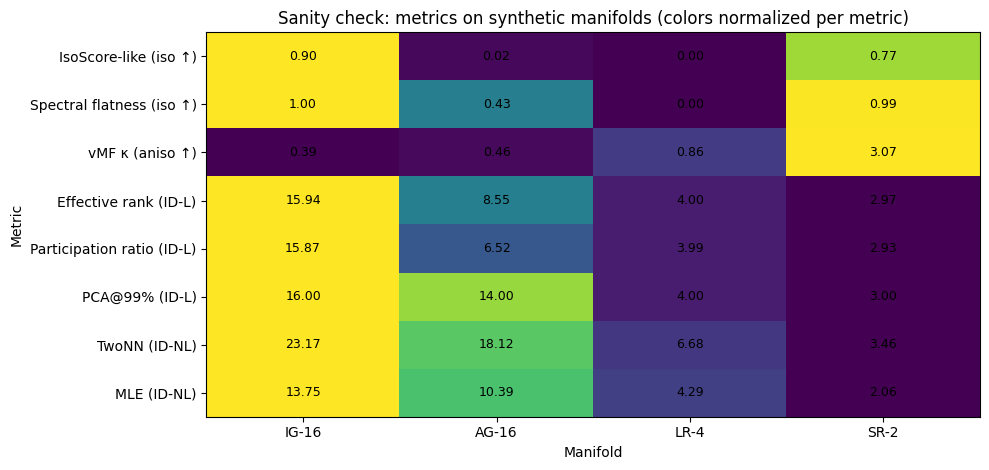

In [7]:
vals = pivot.values.astype(np.float64)
row_min = vals.min(axis=1, keepdims=True)
row_max = vals.max(axis=1, keepdims=True)
norm = (vals - row_min) / (row_max - row_min + EPS)

fig, ax = plt.subplots(figsize=(10, 4.8))
ax.imshow(norm, aspect="auto")

ax.set_xticks(range(pivot.shape[1]))
ax.set_xticklabels(pivot.columns, rotation=0)
ax.set_yticks(range(pivot.shape[0]))
ax.set_yticklabels(pivot.index)

for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        ax.text(j, i, f"{vals[i, j]:.2f}", ha="center", va="center", fontsize=9)

ax.set_title("Sanity check: metrics on synthetic manifolds ")
ax.set_xlabel("Manifold")
ax.set_ylabel("Metric")

plt.tight_layout()

if SAVE_FIG:
    fig.savefig(FIG_PATH, dpi=200, bbox_inches="tight")

plt.show()
